<a href="https://colab.research.google.com/github/mariron42/FisicaComputacional-1/blob/main/Actividad%206/%20Actividad_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Pronóstico de Series de Tiempo
# Feb 15, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline


In [ ]:
url = 'https://raw.githubusercontent.com/FerminDelgadoR/FisicaComputacional1/master/Actividad%203/Datos%20climatologicos.txt'

my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()

#df_meteo.info()
#print(df_meteo.head())
#print(df_meteo.tail())

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()
#print(df_meteo_ts.head())
#print(df_meteo_ts.tail())

# Seleccionaremos un conjunto de años de 30 años, creando las colecciones de datos 
df_30 = df_meteo_ts[(df_meteo_ts['Año'] >= 1930) & (df_meteo_ts['Año'] < 1960)]
df_60 = df_meteo_ts[(df_meteo_ts['Año'] >= 1960) & (df_meteo_ts['Año'] < 1990)]
df_90 = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2018)]

# Estas 3 colecciones serán nuestras Series de Tiempo (DatFrames) para el análisis



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20300 entries, 1961-01-01 to 2016-09-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  20292 non-null  float64
 1   Evap    9638 non-null   float64
 2   Tmax    20196 non-null  float64
 3   Tmin    20196 non-null  float64
 4   Año     20300 non-null  int64  
 5   Mes     20300 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ MB


In [ ]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [ ]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2017 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '2000-01', '2011-12'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()




,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2000-01-01,0.0,3.9,24.5,13.0,2000,Jan
2000-01-02,0.0,1.8,22.0,6.5,2000,Jan
2000-01-03,0.0,1.1,23.5,7.0,2000,Jan
2000-01-04,0.0,3.3,21.5,6.5,2000,Jan
2000-01-05,0.0,3.3,21.5,7.5,2000,Jan


In [ ]:
# Vemos su encabezado
ts_90['Tmax'].head()


Fecha
2000-01-01    24.5
2000-01-02    22.0
2000-01-03    23.5
2000-01-04    21.5
2000-01-05    21.5
Name: Tmax, dtype: float64

In [ ]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico

ts_test = ts_90['Tmax'].copy()



ts_test2 = ts_90['Tmin'].copy()


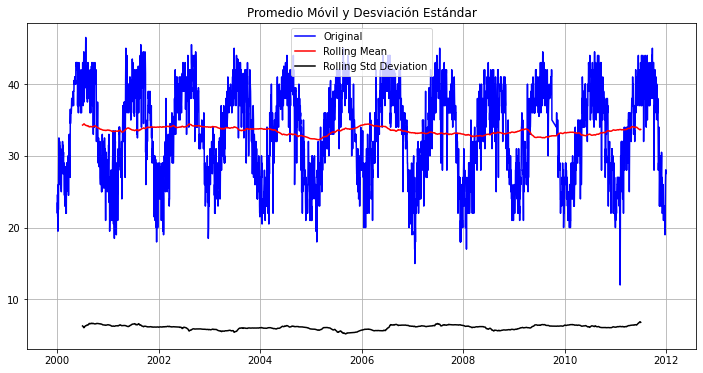

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                         NaN
p-value                                NaN
#Lags Used                        0.000000
Number of Observations Used    4351.000000
Critical Value (1%)              -3.431854
Critical Value (5%)              -2.862205
Critical Value (10%)             -2.567124
dtype: float64


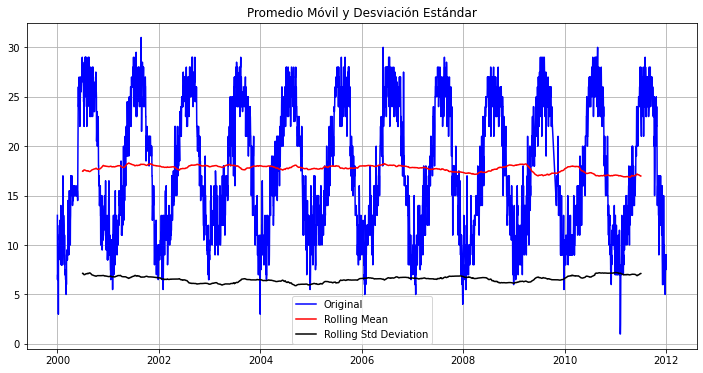

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.955234
p-value                           0.001664
#Lags Used                       24.000000
Number of Observations Used    4327.000000
Critical Value (1%)              -3.431862
Critical Value (5%)              -2.862208
Critical Value (10%)             -2.567126
dtype: float64


In [ ]:
# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test)




test_stationarity(ts_test2)

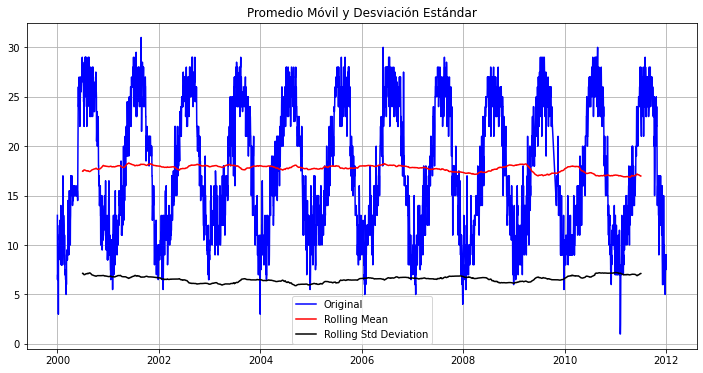

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.955234
p-value                           0.001664
#Lags Used                       24.000000
Number of Observations Used    4327.000000
Critical Value (1%)              -3.431862
Critical Value (5%)              -2.862208
Critical Value (10%)             -2.567126
dtype: float64


In [ ]:

test_stationarity(ts_test2)

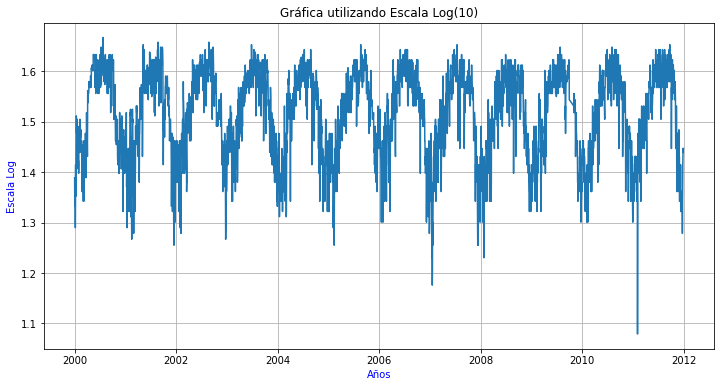

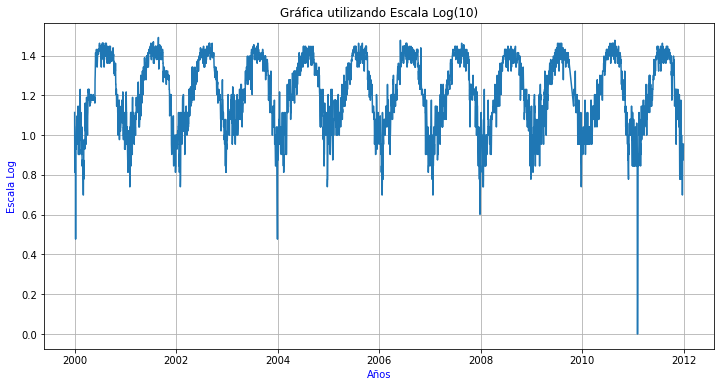

In [ ]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

ts_test_log2 = np.log10(ts_test2)
plt.plot(ts_test_log2)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();



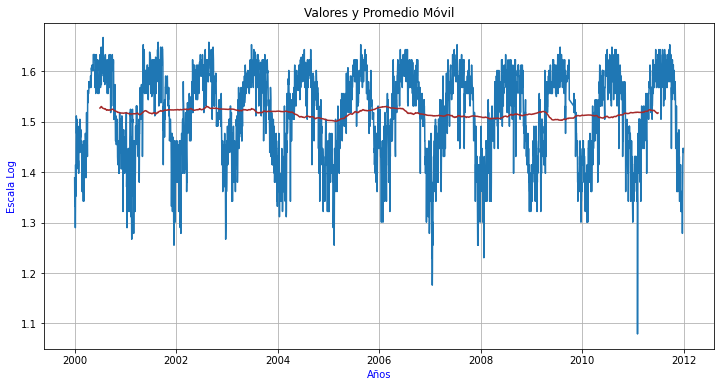

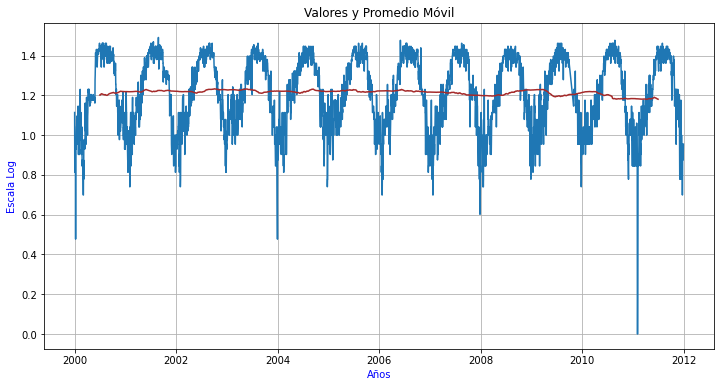

In [ ]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();


moving_avg2 = ts_test_log2.rolling(365, center=True).mean()
plt.plot(ts_test_log2)
plt.plot(moving_avg2, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [ ]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

ts_test_log_moving_ave_diff2 = ts_test_log2 - moving_avg2
ts_test_log_moving_ave_diff2.head()


Fecha
2000-01-01   NaN
2000-01-02   NaN
2000-01-03   NaN
2000-01-04   NaN
2000-01-05   NaN
Name: Tmin, dtype: float64

In [ ]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

ts_test_log_moving_ave_diff2.dropna(inplace=True)
ts_test_log_moving_ave_diff2.head()


Fecha
2000-07-01    0.229695
2000-07-02    0.230132
2000-07-03    0.229562
2000-07-04    0.244765
2000-07-05    0.220174
Name: Tmin, dtype: float64

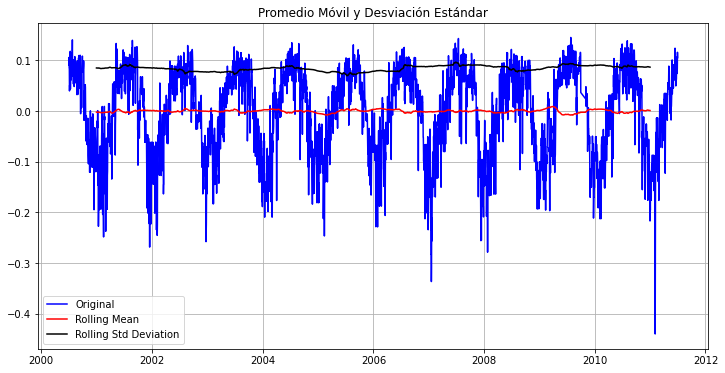

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -4.357342
p-value                           0.000353
#Lags Used                       15.000000
Number of Observations Used    3971.000000
Critical Value (1%)              -3.431998
Critical Value (5%)              -2.862268
Critical Value (10%)             -2.567158
dtype: float64


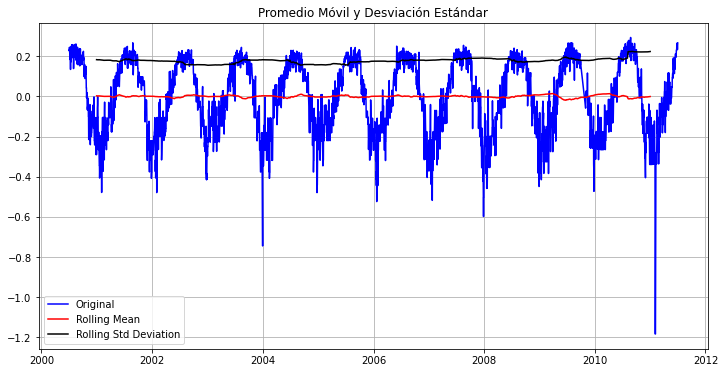

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.601054
p-value                           0.005741
#Lags Used                       16.000000
Number of Observations Used    3971.000000
Critical Value (1%)              -3.431998
Critical Value (5%)              -2.862268
Critical Value (10%)             -2.567158
dtype: float64


In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

test_stationarity(ts_test_log_moving_ave_diff2)


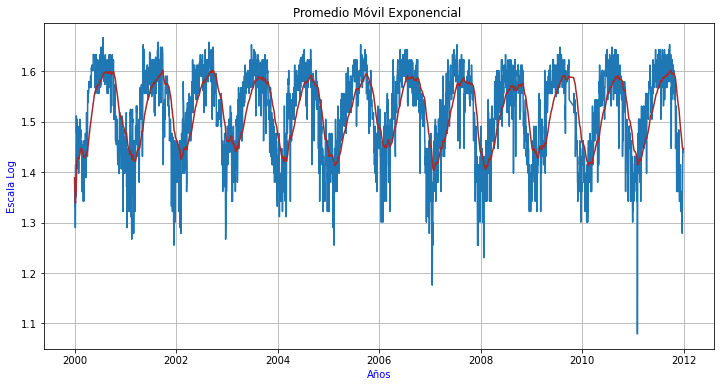

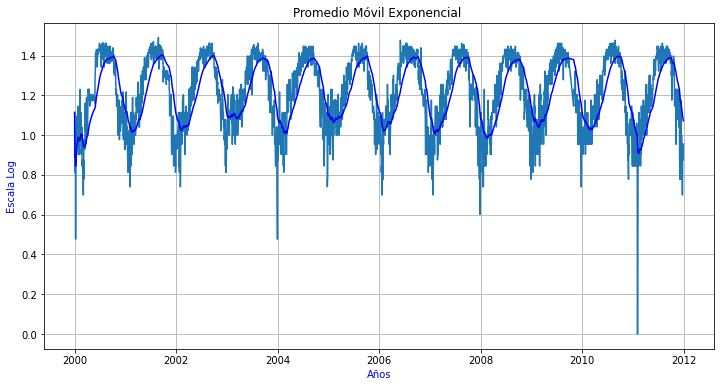

In [ ]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();


EWM_avg2 = ts_test_log2.ewm(halflife=30).mean()
plt.plot(ts_test_log2)
plt.plot(EWM_avg2, color = 'blue')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [ ]:
EWM_avg.head()


Fecha
2000-01-01    1.389166
2000-01-02    1.365524
2000-01-03    1.367415
2000-01-04    1.358366
2000-01-05    1.352938
Name: Tmax, dtype: float64

In [ ]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg 

ts_test_log_EWM_avg_diff2 = ts_test_log2 - EWM_avg2 

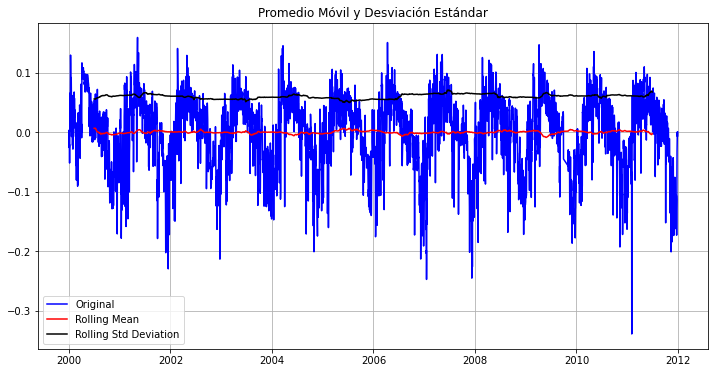

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                         NaN
p-value                                NaN
#Lags Used                        0.000000
Number of Observations Used    4351.000000
Critical Value (1%)              -3.431854
Critical Value (5%)              -2.862205
Critical Value (10%)             -2.567124
dtype: float64


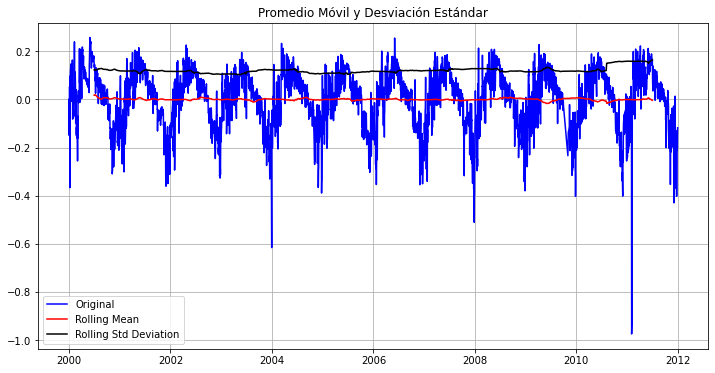

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -4.540294
p-value                           0.000166
#Lags Used                       20.000000
Number of Observations Used    4331.000000
Critical Value (1%)              -3.431861
Critical Value (5%)              -2.862208
Critical Value (10%)             -2.567125
dtype: float64


In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)
test_stationarity(ts_test_log_EWM_avg_diff2)

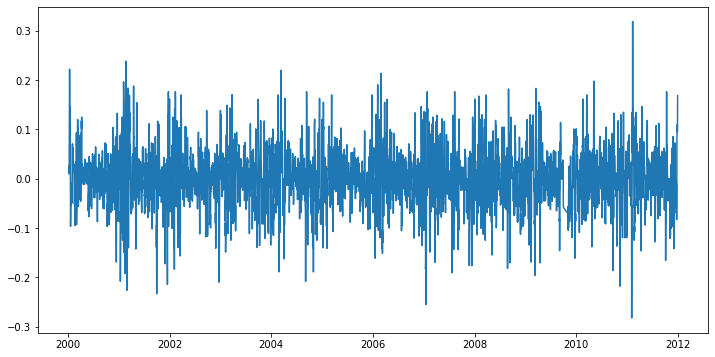

In [ ]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);



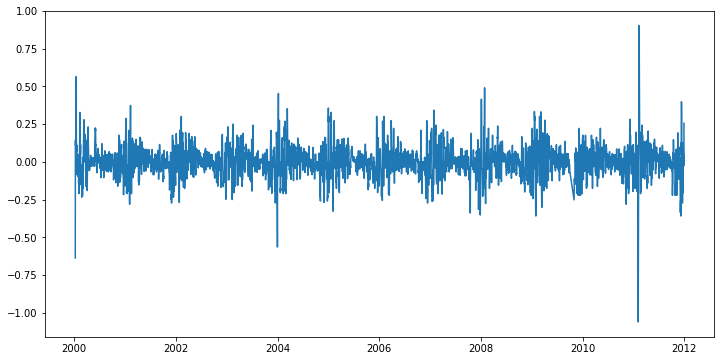

In [ ]:
ts_test_log_diff2 = ts_test_log2 - ts_test_log2.shift(periods=7)
plt.plot(ts_test_log_diff2);

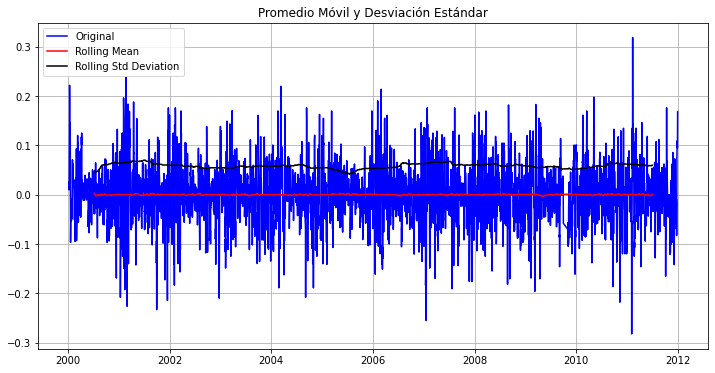

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.186949e+01
p-value                        6.554675e-22
#Lags Used                     2.800000e+01
Number of Observations Used    4.315000e+03
Critical Value (1%)           -3.431866e+00
Critical Value (5%)           -2.862210e+00
Critical Value (10%)          -2.567127e+00
dtype: float64


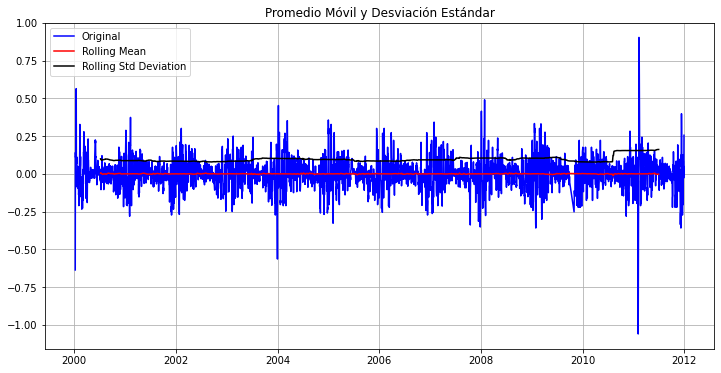

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.599125e+00
p-value                        1.941903e-16
#Lags Used                     3.000000e+01
Number of Observations Used    4.314000e+03
Critical Value (1%)           -3.431867e+00
Critical Value (5%)           -2.862210e+00
Critical Value (10%)          -2.567127e+00
dtype: float64


In [ ]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

ts_test_log_diff2.dropna(inplace=True)
test_stationarity(ts_test_log_diff2)

In [ ]:
# Número de datos utilizados
len(ts_test_log_diff)

4344

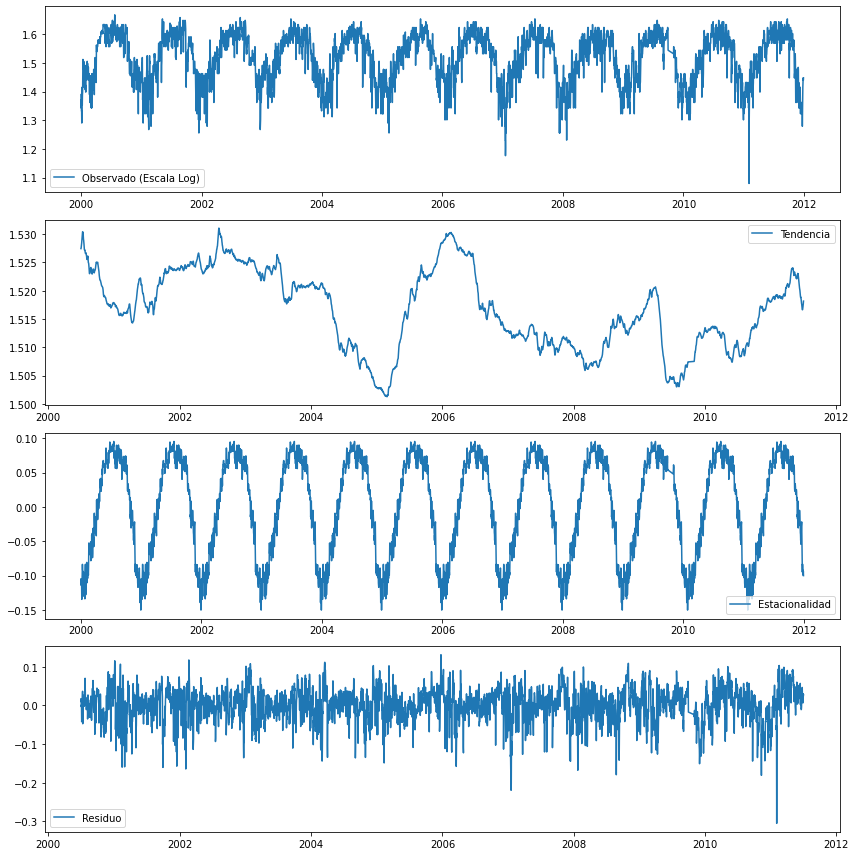

In [ ]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();



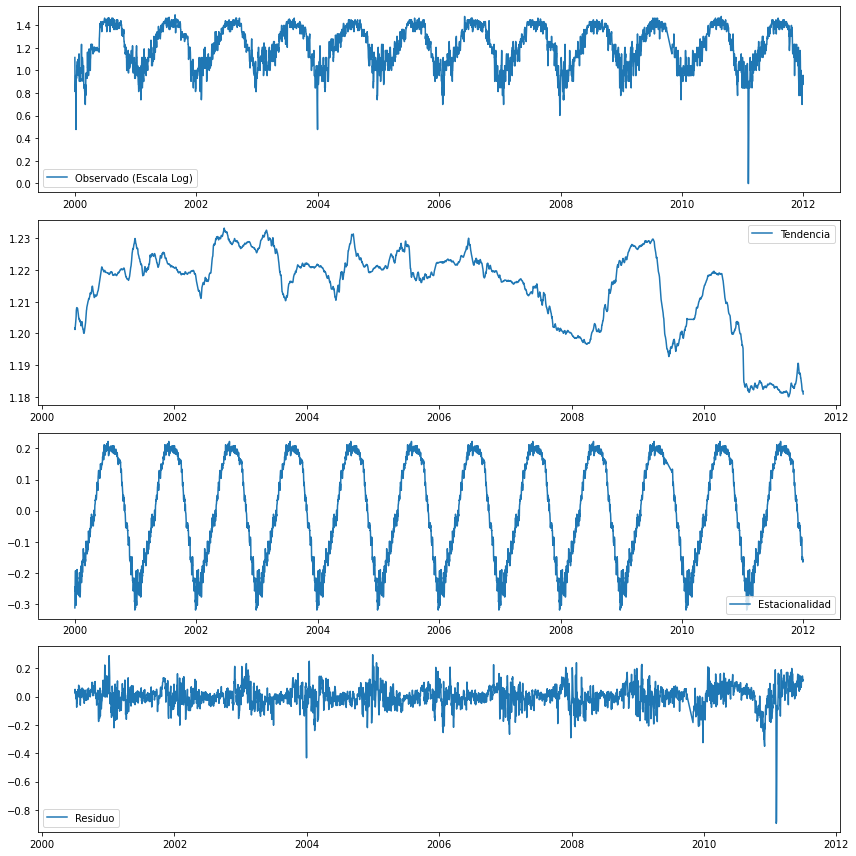

In [ ]:
# Método de descomposición usando la biblioteca statsmodels.tsa de la temperaturas minimas

decomposition2 = sm.tsa.seasonal_decompose(ts_test_log2.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend2 = decomposition2.trend
seasonal2 = decomposition2.seasonal
residue2 = decomposition2.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log2, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend2, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal2, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue2, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

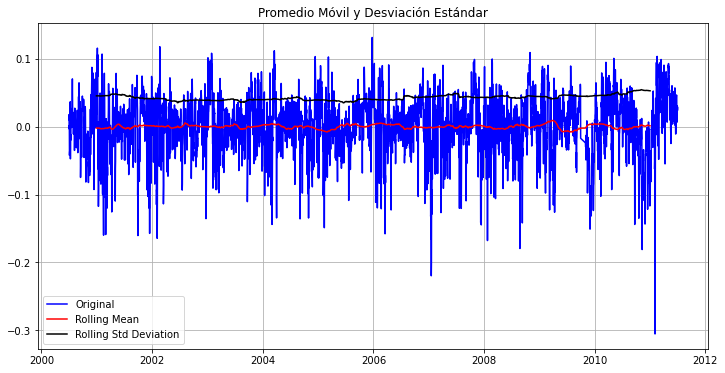

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.415491e+00
p-value                        2.049121e-13
#Lags Used                     2.800000e+01
Number of Observations Used    3.959000e+03
Critical Value (1%)           -3.432003e+00
Critical Value (5%)           -2.862270e+00
Critical Value (10%)          -2.567159e+00
dtype: float64


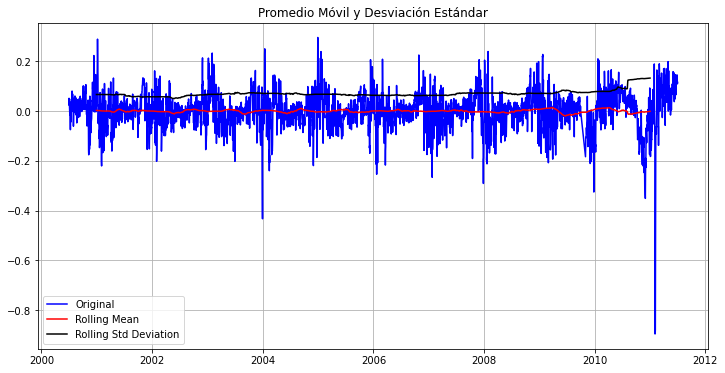

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.375365e+00
p-value                        2.594970e-13
#Lags Used                     2.000000e+01
Number of Observations Used    3.967000e+03
Critical Value (1%)           -3.431999e+00
Critical Value (5%)           -2.862269e+00
Critical Value (10%)          -2.567158e+00
dtype: float64


In [ ]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)



ts_test_log_decompose2 = residue2 
ts_test_log_decompose2.dropna(inplace=True)
test_stationarity(ts_test_log_decompose2)

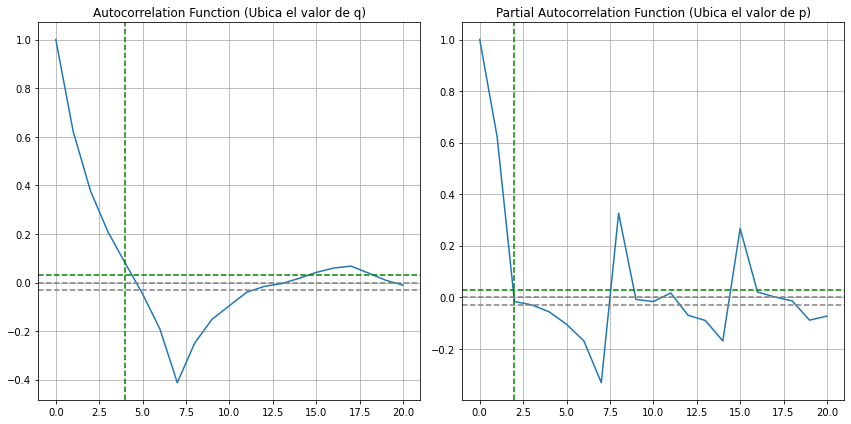

In [ ]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()



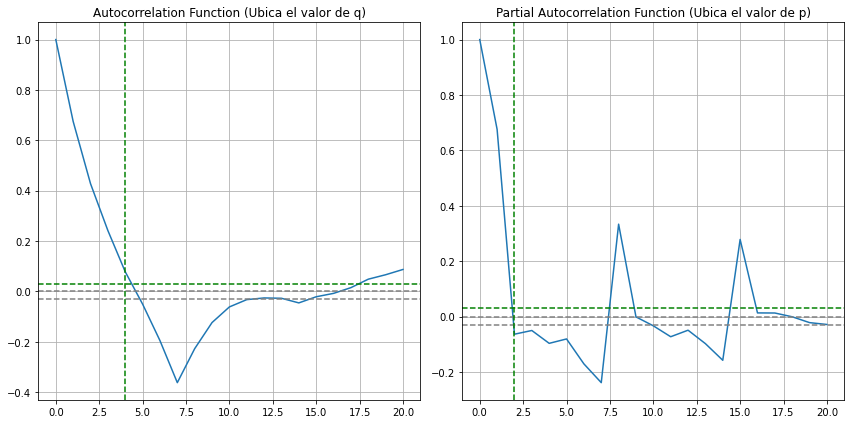

In [ ]:
lag_acf2 = acf(ts_test_log_diff2, nlags=20)
lag_pacf2 = pacf(ts_test_log_diff2, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf2)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff2)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff2)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf2)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff2)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff2)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 4350
Model:                 ARIMA(2, 1, 0)   Log Likelihood                8519.353
Method:                       css-mle   S.D. of innovations              0.034
Date:                Tue, 23 Feb 2021   AIC                         -17030.707
Time:                        05:20:31   BIC                         -17005.195
Sample:                             1   HQIC                        -17021.702
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          1.51e-05      0.000      0.039      0.969      -0.001       0.001
ar.L1.D.Tmax    -0.1948      0.015    -13.010      0.000      -0.224      -0.165
ar.L2.D.Tmax    -0.1575      0.015    -10.52

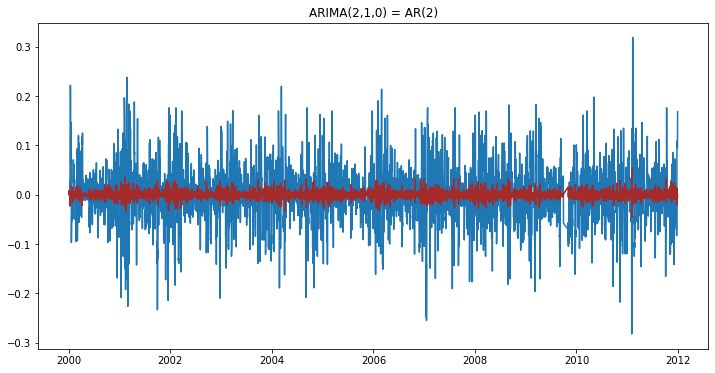

In [ ]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 4351
Model:                 ARIMA(2, 1, 0)   Log Likelihood                6315.596
Method:                       css-mle   S.D. of innovations              0.057
Date:                Tue, 23 Feb 2021   AIC                         -12623.191
Time:                        05:20:31   BIC                         -12597.678
Sample:                             1   HQIC                        -12614.186
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.569e-05      0.001     -0.038      0.970      -0.001       0.001
ar.L1.D.Tmin    -0.1433      0.015     -9.507      0.000      -0.173      -0.114
ar.L2.D.Tmin    -0.1345      0.015     -8.92

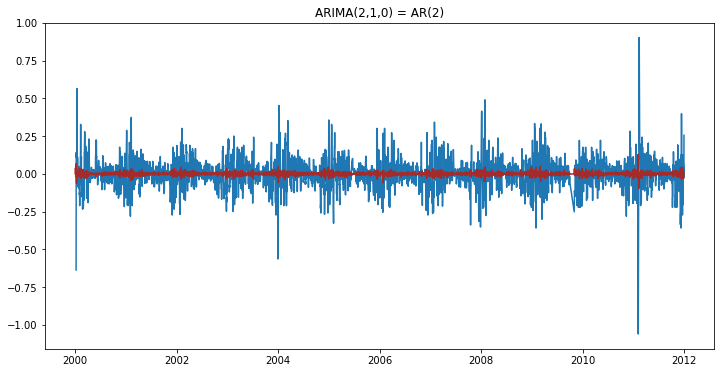

In [ ]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model2 = ARIMA(ts_test_log2, order=(2,1,0), missing='drop')
results_AR2 = model2.fit(displ=-1)
plt.plot(ts_test_log_diff2)
plt.plot(results_AR2.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR2.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 4350
Model:                 ARIMA(0, 1, 4)   Log Likelihood                8666.219
Method:                       css-mle   S.D. of innovations              0.033
Date:                Tue, 23 Feb 2021   AIC                         -17320.439
Time:                        05:20:32   BIC                         -17282.171
Sample:                             1   HQIC                        -17306.931
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.946e-06      0.000      0.044      0.965      -0.000       0.000
ma.L1.D.Tmax    -0.2796      0.015    -18.549      0.000      -0.309      -0.250
ma.L2.D.Tmax    -0.1977      0.015    -12.77

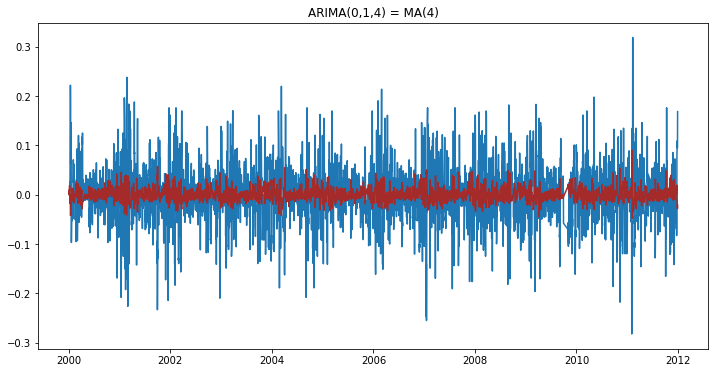

In [ ]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 4351
Model:                 ARIMA(0, 1, 4)   Log Likelihood                6446.977
Method:                       css-mle   S.D. of innovations              0.055
Date:                Tue, 23 Feb 2021   AIC                         -12881.955
Time:                        05:20:33   BIC                         -12843.686
Sample:                             1   HQIC                        -12868.447
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.069e-05      0.000     -0.035      0.972      -0.001       0.001
ma.L1.D.Tmin    -0.2174      0.015    -14.442      0.000      -0.247      -0.188
ma.L2.D.Tmin    -0.1822      0.015    -11.95

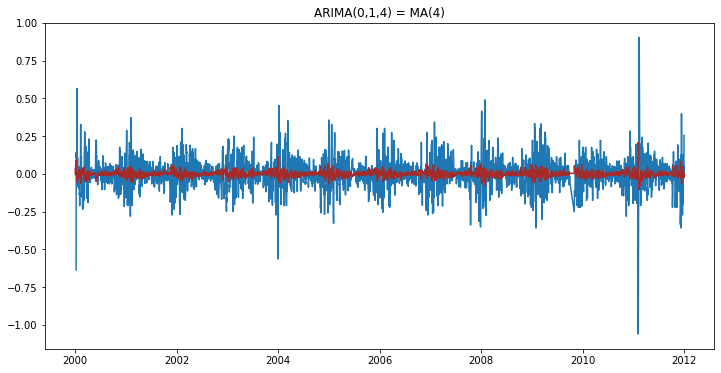

In [ ]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log2, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff2)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 4350
Model:                 ARIMA(2, 1, 4)   Log Likelihood                8672.469
Method:                       css-mle   S.D. of innovations              0.033
Date:                Tue, 23 Feb 2021   AIC                         -17328.937
Time:                        05:20:37   BIC                         -17277.914
Sample:                             1   HQIC                        -17310.927
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.305e-06      0.000      0.030      0.976      -0.000       0.000
ar.L1.D.Tmax    -0.2190      0.192     -1.140      0.254      -0.596       0.158
ar.L2.D.Tmax     0.3977      0.094      4.20

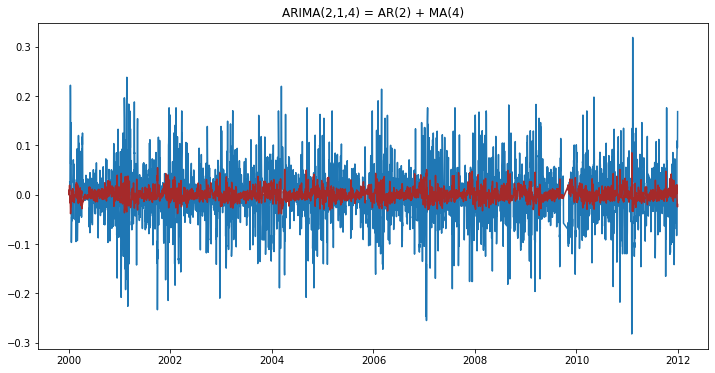

In [ ]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 4351
Model:                 ARIMA(2, 1, 4)   Log Likelihood                6451.134
Method:                       css-mle   S.D. of innovations              0.055
Date:                Tue, 23 Feb 2021   AIC                         -12886.269
Time:                        05:20:43   BIC                         -12835.243
Sample:                             1   HQIC                        -12868.259
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.116e-05      0.000     -0.038      0.970      -0.001       0.001
ar.L1.D.Tmin     0.5807      0.279      2.079      0.038       0.033       1.128
ar.L2.D.Tmin    -0.1873      0.152     -1.23

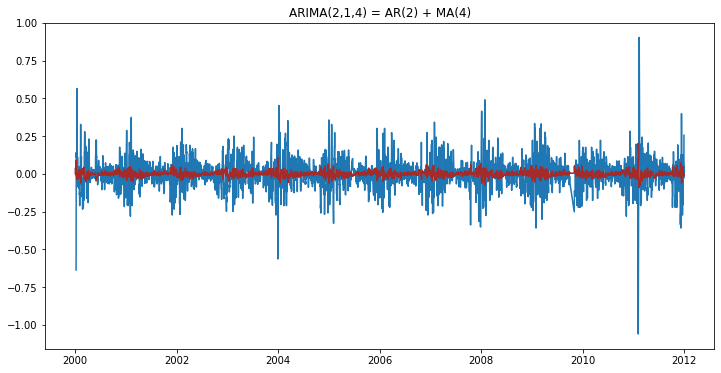

In [ ]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log2, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff2)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [ ]:
#AIC de las graficas de temperatura maxima
#1)-11450.095
#2)-11658.235
#3)-11664.924  Este es el menor AIC de los 3 graficas de temperatura minima, usaremos este que pertenece a la ultima grafica que hicimos

#AIC de las graficas de temperatura minima
#1)-8810.251
#2)-8968.845   Este es el menor AIC de los 3 graficas de temperatura minima, usaremos este que pertenece a la ultima grafica que hicimos
#3)-8966.730 

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 4350
Model:                 ARIMA(2, 1, 4)   Log Likelihood                8672.469
Method:                       css-mle   S.D. of innovations              0.033
Date:                Tue, 23 Feb 2021   AIC                         -17328.937
Time:                        05:20:48   BIC                         -17277.914
Sample:                             1   HQIC                        -17310.927
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4.305e-06      0.000      0.030      0.976      -0.000       0.000
ar.L1.D.Tmax    -0.2190      0.192     -1.140      0.254      -0.596       0.158
ar.L2.D.Tmax     0.3977      0.094      4.20

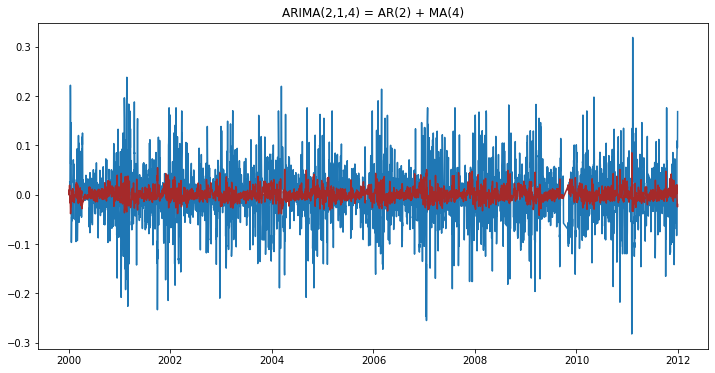

In [ ]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA para las temperaturas maximas
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())


In [ ]:

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)


Fecha
2000-01-02    0.000004
2000-01-03    0.007870
2000-01-04    0.001866
2000-01-05    0.010081
2000-01-06    0.007955
                ...   
2011-12-26   -0.014305
2011-12-27   -0.020482
2011-12-28   -0.022584
2011-12-29   -0.024669
2011-12-30   -0.019916
Length: 4350, dtype: float64


In [ ]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())



Fecha
2000-01-01         NaN
2000-01-02    1.342427
2000-01-03    1.378937
2000-01-04    1.334304
2000-01-05    1.342520
dtype: float64
Fecha
2011-12-27    1.410882
2011-12-28    1.424574
2011-12-29    1.414664
2011-12-30    1.427242
2011-12-31         NaN
dtype: float64


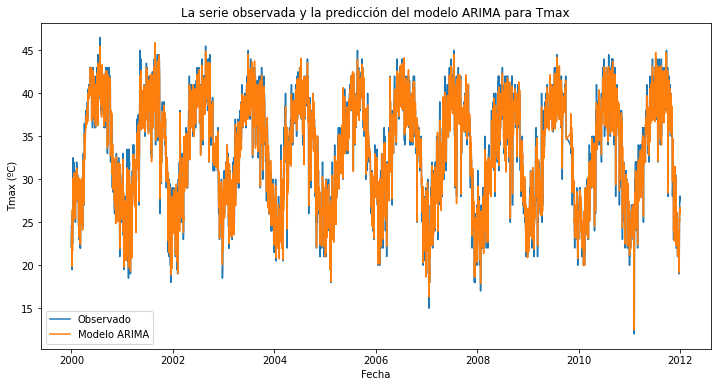

In [ ]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');


In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)


RMSE: 0.8534478784385091


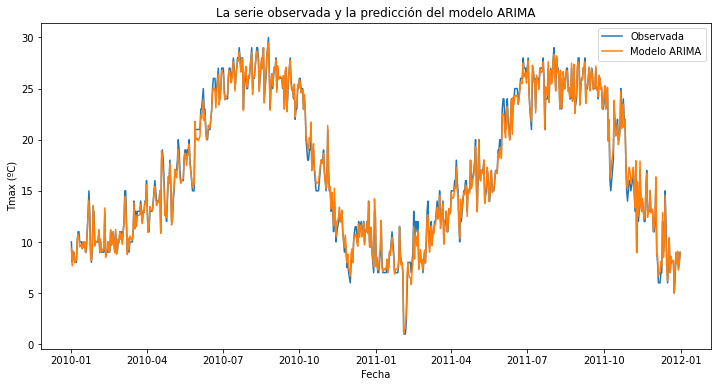

In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test2.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');


In [ ]:
#Ahora calculando para las temperaturas minimas

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 4351
Model:                 ARIMA(2, 1, 4)   Log Likelihood                6451.134
Method:                       css-mle   S.D. of innovations              0.055
Date:                Tue, 23 Feb 2021   AIC                         -12886.269
Time:                        05:20:54   BIC                         -12835.243
Sample:                             1   HQIC                        -12868.259
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.116e-05      0.000     -0.038      0.970      -0.001       0.001
ar.L1.D.Tmin     0.5807      0.279      2.079      0.038       0.033       1.128
ar.L2.D.Tmin    -0.1873      0.152     -1.23

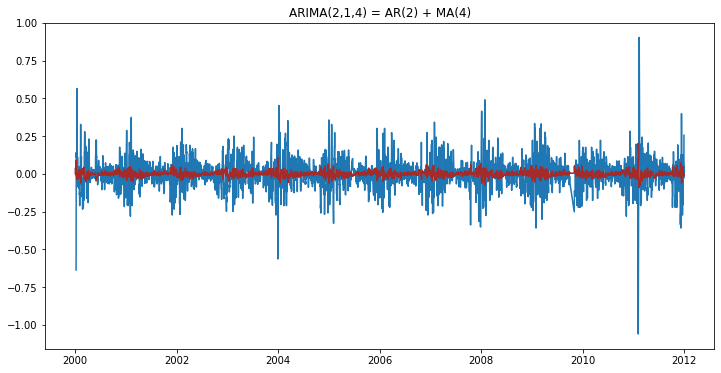

In [ ]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log2, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff2)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [ ]:

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)


Fecha
2000-01-02   -0.000011
2000-01-03    0.038017
2000-01-04    0.035904
2000-01-05    0.032840
2000-01-06    0.032674
                ...   
2011-12-27   -0.007014
2011-12-28    0.004294
2011-12-29   -0.014604
2011-12-30   -0.004408
2011-12-31   -0.003991
Length: 4351, dtype: float64


In [ ]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log2, index = ts_test_log2.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())



Fecha
2000-01-01         NaN
2000-01-02    0.812902
2000-01-03    0.883115
2000-01-04    0.848817
2000-01-05    0.907901
dtype: float64
Fecha
2011-12-27    0.896076
2011-12-28    0.958537
2011-12-29    0.860457
2011-12-30    0.898682
2011-12-31    0.950251
dtype: float64


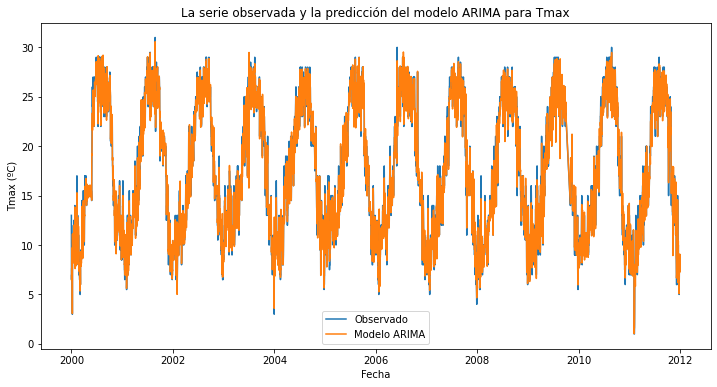

In [ ]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test2, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');


In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test2)**2))
print('RMSE:', RMSE)


RMSE: 0.5322472717199944


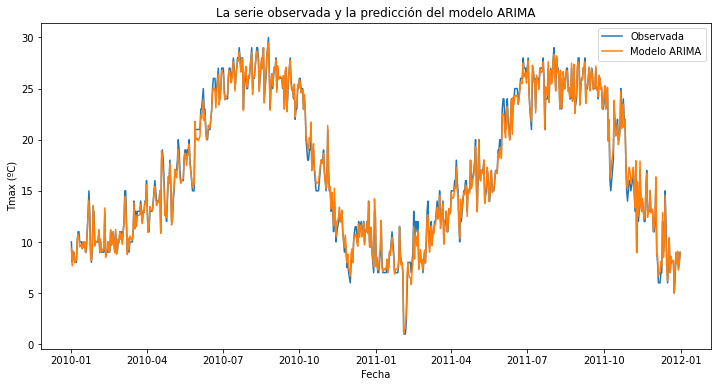

In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test2.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');
